# Socioeconomic Analysis — Chicago Community Areas (SQL + SQLite)

**Goal.** Show how to load and explore Chicago neighborhood socioeconomic data from scratch using SQL and a local SQLite database.

**Key questions:**
- How are per-capita income (*PER_CAPITA_INCOME_*) and the *HARDSHIP_INDEX* distributed across neighborhoods?
- Which neighborhoods are in the worst condition (unemployment, poverty, education)?
- Is there a simple relationship between income and hardship?

**Data:**  
Socioeconomic indicators for Chicago neighborhoods from the city’s open data portal:  
[Chicago Data Portal – Socioeconomic Indicators](https://data.cityofchicago.org/Health-Human-Services/Socioeconomic-Indicators/jcxq-k9xf)

**Key fields:**  
`COMMUNITY_AREA_NUMBER`, `COMMUNITY_AREA_NAME`, `PER_CAPITA_INCOME_`, `HARDSHIP_INDEX`,  
`PERCENT_HOUSEHOLDS_BELOW_POVERTY`, `PERCENT_AGED_16_UNEMPLOYED`,  
`PERCENT_AGED_25__WITHOUT_HIGH_SCHOOL_DIPLOMA`, etc.

**What’s inside the notebook:**
1. Data loading and preparation (CSV → SQLite).
2. Basic SQL analysis: descriptive stats, filtering, simple aggregates.
3. Analytical queries: sorting, grouping, nested subqueries.
4. Visualization: scatter plot of income vs. hardship index.

> This notebook is part of a learning portfolio on SQL and data analytics.


## 1. Environment Setup

Import the necessary libraries and enable the **SQL magic** extension for Jupyter.  
This will allow you to run SQL queries directly from notebook cells.


In [2]:
# Install required extensions (if already installed, nothing changes):
# - ipython-sql: run SQL directly in Jupyter with %sql magic
# - prettytable: nicely formatted SQL query results as tables
# - seaborn: for charts and visualizations
#!pip install -q ipython-sql prettytable seaborn

# Import necessary libraries
import sqlite3
import pandas as pd
import prettytable
import matplotlib.pyplot as plt
import seaborn as sns

# Configure prettytable for nicer output
prettytable.DEFAULT = 'DEFAULT'

# Load the SQL extension for Jupyter
%load_ext sql


The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## 2. Creating and Connecting to the Local SQLite Database (pandas + sqlite3)

First, create or open the database file **socioeconomic.db** using Python’s built-in `sqlite3` library.  
Through the `con` object we can work with the database from Python (e.g., load data into it via `pandas.to_sql`),  
and the `cur` object will allow us to execute administrative SQL commands directly.


In [3]:
# Create (or open if it already exists) the local database socioeconomic.db
con = sqlite3.connect("socioeconomic.db")

# Create a cursor to execute SQL commands directly
cur = con.cursor()


## 3. Connecting `%sql` magic to the database

To run SQL queries directly in Jupyter, we’ll link the `%sql` extension to our **socioeconomic.db** database.  
This will let us write SQL commands in separate notebook cells and instantly see tabular results.


In [4]:
%sql sqlite:///socioeconomic.db


## 4. Loading the dataset into a SQLite table

Load Chicago’s socioeconomic data from `chicago_socioeconomic.csv`.  
Using `pandas.read_csv`, we’ll read the CSV into a DataFrame and then store it in **socioeconomic.db**  
under the name `chicago_socioeconomic_data`.

Parameters:
- `if_exists="replace"` — overwrite the table if it already exists  
- `index=False` — don’t save the pandas index as a column  
- `method="multi"` — optimize the insert by batching

Finally, we’ll check the number of rows (expecting **78** records).


In [5]:
# Source: https://data.cityofchicago.org/resource/jcxq-k9xf.csv
df = pd.read_csv("data/chicago_socioeconomic.csv")

# Save the DataFrame into the SQLite table chicago_socioeconomic_data
df.to_sql(
    "chicago_socioeconomic_data",
    con,
    if_exists="replace",
    index=False,
    method="multi"
)

# Check the number of rows (should be 78)
len(df)


78

## 5. Quick table content check

Make sure the data has been successfully written into SQLite.  
Run a simple SQL query to display the first 5 rows of the `chicago_socioeconomic_data` table.


In [6]:
%sql SELECT * FROM chicago_socioeconomic_data LIMIT 5;


 * sqlite:///socioeconomic.db
Done.


ca,community_area_name,percent_of_housing_crowded,percent_households_below_poverty,percent_aged_16_unemployed,percent_aged_25_without_high_school_diploma,percent_aged_under_18_or_over_64,per_capita_income_,hardship_index
1.0,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39.0
2.0,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46.0
3.0,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20.0
4.0,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17.0
5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0


## 6. Basic SQL Queries

Let's start by answering a few simple questions about the data:  
- How many rows does the table contain?  
- How many community areas have a high `hardship_index`?  
- What is the maximum value of the hardship index?  
- Which community area is the most disadvantaged?  
- Which areas stand out with high per capita income?  


 Determine how many rows (community areas) the table `chicago_socioeconomic_data` contains.


In [7]:
%sql SELECT COUNT(*) FROM chicago_socioeconomic_data;


 * sqlite:///socioeconomic.db
Done.


COUNT(*)
78


👉 **Result:** 78 rows — meaning the dataset contains **78 community areas of Chicago**.

Count how many community areas have a **Hardship Index** greater than 50.


In [11]:
%sql SELECT COUNT(*) FROM chicago_socioeconomic_data WHERE hardship_index > 50.0;


 * sqlite:///socioeconomic.db
Done.


COUNT(*)
38


👉 **Result:** 38 community areas have a **Hardship Index** greater than 50.

Find the maximum value of the Hardship Index (`hardship_index`).


In [8]:
%sql SELECT MAX(hardship_index) FROM chicago_socioeconomic_data;


 * sqlite:///socioeconomic.db
Done.


MAX(hardship_index)
98.0


👉 The result shows the highest Hardship Index level — **98** among all 78 community areas.

 Determine which community area has the highest **Hardship Index**.


In [9]:
%%sql SELECT community_area_name 
FROM chicago_socioeconomic_data 
WHERE hardship_index = ( 
    SELECT MAX(hardship_index) 
    FROM chicago_socioeconomic_data 
);


 * sqlite:///socioeconomic.db
Done.


community_area_name
Riverdale


👉 Result: **Riverdale** is the community area with the highest Hardship Index.

Find the community areas where **per_capita_income_** exceeds 60,000.


In [10]:
%%sql SELECT community_area_name 
FROM chicago_socioeconomic_data 
WHERE per_capita_income_ > 60000 
ORDER BY per_capita_income_ DESC;


 * sqlite:///socioeconomic.db
Done.


community_area_name
Near North Side
Lincoln Park
Loop
Lake View


👉 **Result:** the list of the most affluent Chicago community areas: **Near North Side, Lincoln Park, Loop, Lake View**.


## 7. Analysis: Relationship Between Income and Hardship Index

For clarity, let's build a **scatter plot** of `per_capita_income_` (per capita income) vs. `hardship_index` (hardship index).  

The chart also shows the distributions along each axis. Each point represents one **Chicago community area**.


 * sqlite:///socioeconomic.db
Done.


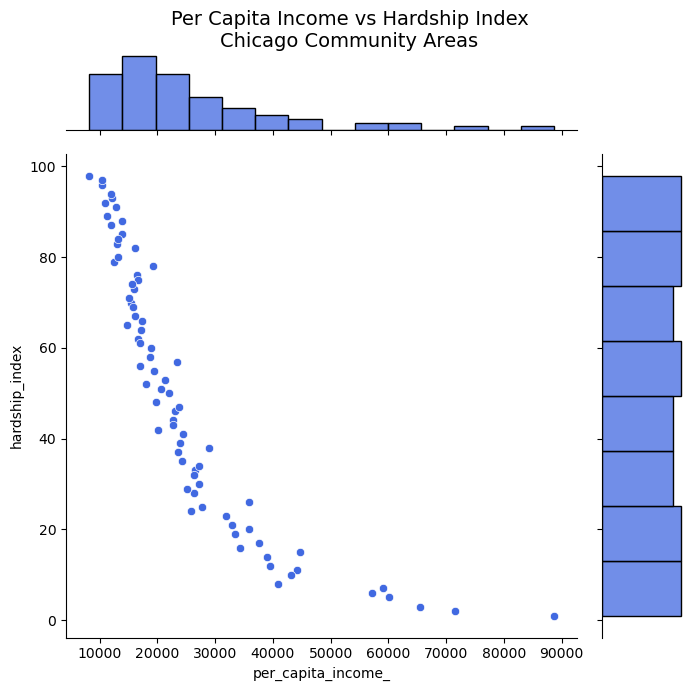

In [11]:
# Load data from SQLite directly into a pandas DataFrame
income_vs_hardship = %sql SELECT per_capita_income_, hardship_index FROM chicago_socioeconomic_data;

df_plot = income_vs_hardship.DataFrame()

# Build a scatter plot with histograms along each axis
plot = sns.jointplot(
    x='per_capita_income_', 
    y='hardship_index',
    data=df_plot,
    kind="scatter",
    height=7,
    space=0.3,
    color="royalblue"
)

# Add title
plt.suptitle("Per Capita Income vs Hardship Index\nChicago Community Areas", fontsize=14)
plt.subplots_adjust(top=0.92)  # move title a bit higher

# Save the plot as SVG before showing it
plt.savefig("images/income_vs_hardship.svg")

plt.show()


### Insights from the Plot

- There is a **negative correlation** between per capita income and the hardship index.  
- At low income levels (10–20K), the hardship index is almost always high (70–100).  
- When income rises above 40K, the hardship index drops sharply (<20).  
- The few neighborhoods with incomes of 60–90K almost do not experience social hardship.  

## Conclusion  

This analysis used data from 78 Chicago community areas.  
It shows that **the higher the income, the fewer social hardships**.  
Low-income neighborhoods are high-hardship zones, while affluent ones have minimal problems.
